# Importing required libraries

In [1]:
print("ss")

ss


In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import albumentations as A
import cv2


import os

from PIL import Image
from pathlib import Path
from tqdm.auto import tqdm
import multiprocessing as mp
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import io, transforms
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.transforms.functional import to_pil_image

from transformers import Seq2SeqTrainer ,Seq2SeqTrainingArguments
from transformers import VisionEncoderDecoderModel , ViTFeatureExtractor
from transformers import AutoTokenizer ,  GPT2Config , default_data_collator


from transformers import GPT2LMHeadModel, GPT2TokenizerFast, get_linear_schedule_with_warmup

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from timm import create_model, list_models
from types import SimpleNamespace
from transformers import GPT2LMHeadModel, GPT2TokenizerFast, get_linear_schedule_with_warmup
import albumentations as A
from albumentations.pytorch import ToTensorV2
from PIL import Image
from pathlib import Path
from sklearn.model_selection import train_test_split
from torch.cuda.amp import GradScaler, autocast
from tqdm.auto import tqdm
import gc
import json
import seaborn as sns

2024-04-26 15:26:45.461788: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-26 15:26:45.461899: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-26 15:26:45.711349: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
# To ignore warinings
import warnings
warnings.filterwarnings('ignore')

# Checking GPUs

In [4]:
if torch.cuda.is_available():    

    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 2 GPU(s) available.
We will use the GPU: Tesla T4


# Hyperparameter

In [5]:
os.environ["WANDB_DISABLED"] = "true"
#Disabling W&B during development or testing phases to avoid unnecessary overhead or interactions with external services.

# Loading Data from CSV Files

In [6]:
df = pd.read_csv('/kaggle/input/dataset-final/output.csv')
df['caption'] = df['caption'].str.replace('"', '')

In [7]:
df

,image,caption
0,VizWiz_val_00000000.jpg,A computer screen shows a repair prompt on the...
1,VizWiz_val_00000000.jpg,a computer screen with a repair automatically ...
2,VizWiz_val_00000000.jpg,partial computer screen showing the need of re...
3,VizWiz_val_00000000.jpg,Part of a computer monitor showing a computer ...
4,VizWiz_val_00000000.jpg,The top of a laptop with a blue background and...
...,...,...
38745,VizWiz_val_00007749.jpg,A closeup of fiat with a value of 10 on a kit...
38746,VizWiz_val_00007749.jpg,a single piece of Australian currency sitting ...
38747,VizWiz_val_00007749.jpg,An Australian monetary bill with the value of ...
38748,VizWiz_val_00007749.jpg,An Australian ten dollar bill sitting on a bro...


In [8]:
split_index = int(0.8 * len(df))

In [9]:
train_df = df.iloc[:split_index]
eval_df = df.iloc[split_index:]

# Custom Dataset Class for Image Captioning

The code cell defines a custom PyTorch dataset class called Dataset, which is designed for loading, processing, and saving image-caption datasets. Here's a brief summary of its functionalities:

Initialization:

The class is initialized with parameters including a Pandas DataFrame (df) containing image filenames and captions, a transformation function (transform), a code indicating dataset type (train, val, or test), and the path to the folder containing images.
It sets attributes such as the DataFrame, transformation function, dataset code, image folder path, and dataset path based on the provided code.
Data Loading:

The __getitem__ method retrieves a sample from the dataset specified by index (idx).
It loads the original image and applies transformations using the provided transformation function.
The method returns a tuple containing the original image, augmented image, caption, and image filename.
Data Saving:

The save_data method saves both original and augmented images along with their captions to a specified folder.
It creates a subfolder named "train" within the specified save folder to store the images.
The method iterates over each sample in the dataset, saves the original and augmented images as separate files, and stores their filenames and captions.
It generates a DataFrame with columns for image filenames and captions and saves the DataFrame to a CSV file named "train.csv" in the specified save folder.
Overall, this Dataset class facilitates efficient handling of image-caption datasets, providing functionalities for data loading, transformation, and saving, essential for training and evaluating image-captioning models.

In [10]:
class Dataset:
    """
    Custom dataset class for loading and processing images and captions.

    Args:
        df (pd.DataFrame): DataFrame containing image filenames and captions.
        transform (callable): Transformations to apply to images.
        code (str): Code indicating whether the dataset is for training, validation, or testing.
        image_folder (str): Path to the folder containing images.

    Attributes:
        df (pd.DataFrame): DataFrame containing image filenames and captions.
        tfms (callable): Transformations to apply to images.
        code (str): Code indicating whether the dataset is for training, validation, or testing.
        image_folder (str): Path to the folder containing images.
        dataset_path (str): Path to the dataset folder based on the provided code.

    Methods:
        __len__: Returns the number of samples in the dataset.
        __getitem__: Retrieves a sample from the dataset.
        save_data: Saves original and augmented images along with captions to a specified folder.
    """

    def __init__(self, df, transform, code, image_folder):
        self.df = df 
        self.tfms = transform
        self.code = code
        self.image_folder = image_folder
        
        if code == 'train':
            self.dataset_path = '/kaggle/input/val-dataset/val/'
        elif code == 'val':
            self.dataset_path = '/kaggle/input/val-dataset/val/'
        elif code == 'test':
            self.dataset_path = '/kaggle/input/val-dataset/val/'
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        """
        Retrieves a sample from the dataset.

        Args:
            idx (int): Index of the sample to retrieve.

        Returns:
            tuple: Tuple containing the original image, augmented image, caption, and image filename.
        """
        row = self.df.iloc[idx]
        image_filename = row['image']
        caption = row['caption']
        
        # Load original image
        original_image_path = os.path.join(self.dataset_path, image_filename)
        original_image = Image.open(original_image_path).convert('RGB')
        
        # Apply transformations
        augmented = self.tfms(image=np.array(original_image))
        augmented_image = augmented['image']
#         original_image = valid_tfms(image=np.array(original_image))['image']
        
        return original_image, augmented_image, caption, image_filename
    
    def save_data(self, save_folder):
        """
        Saves original and augmented images along with captions to a specified folder.

        Args:
            save_folder (str): Path to the folder where images and captions will be saved.
        """
        # Create folder to save images
        train_save_folder = os.path.join(save_folder, 'train')
        os.makedirs(train_save_folder, exist_ok=True)
        
        # List to store image filenames and captions
        image_filenames = []
        captions = []
        
        # Save original and augmented images along with captions
        for idx in range(len(self)):
            original_image, augmented_image, caption, image_filename = self.__getitem__(idx)
            
            # Save original image
            original_image_save_path = os.path.join(train_save_folder, f'original_{image_filename}')
            #original_image_pil = to_pil_image(original_image)
            original_image.save(original_image_save_path)
            
            # Save augmented image
            augmented_image_save_path = os.path.join(train_save_folder, f'augmented_{image_filename}')
            augmented_image_pil = to_pil_image(augmented_image)
            augmented_image_pil.save(augmented_image_save_path)
            
            # Store image filename and caption
            image_filenames.append('original_'+image_filename)
            captions.append(caption)
            image_filenames.append('augmented_'+image_filename)
            captions.append(caption)
        
        # Create DataFrame for image filenames and captions
        save_df = pd.DataFrame({
            'filename': image_filenames,
            'caption': captions
        })
        
        # Save DataFrame to CSV file
        csv_path = os.path.join(save_folder, 'train.csv')
        save_df.to_csv(csv_path, index=False)


# Define transformations for training and validation datasets

The code defines two sets of image transformations: train_tfms for training data and valid_tfms for validation data.

train_tfms includes augmentation techniques like horizontal flip, random brightness/contrast adjustments, color jitter, and random shifting/scaling/rotation.
valid_tfms resizes images to 224x224 pixels, normalizes them, and converts them to PyTorch tensors.
These transformations prepare images for training and validation processes, enhancing model performance and generalization.

In [11]:
train_tfms = A.Compose([
    A.HorizontalFlip(),
    A.RandomBrightnessContrast(),
    #A.ColorJitter(),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.3, rotate_limit=45, p=0.5),
    ToTensorV2()
])

valid_tfms = A.Compose([
    A.Resize(224, 224),
    A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5], always_apply=True),
    ToTensorV2()
])


In [12]:
# Example usage
train_dataset = Dataset(train_df, train_tfms, 'train', '/kaggle/input/val-dataset/val/')
save_folder = '/kaggle/working/saved_data/'
train_dataset.save_data(save_folder)

In [13]:
train_data = pd.read_csv('/kaggle/working/saved_data/train.csv')

In [22]:
train_rows = int(0.8 * len(train_data))
val_rows = len(train_data) - train_rows

# Split the data into training and validation sets
val_data = train_data[train_rows:]
train_data = train_data[:train_rows]

In [23]:
train_data.head()


,filename,caption
0,original_VizWiz_val_00000000.jpg,A computer screen shows a repair prompt on the...
1,augmented_VizWiz_val_00000000.jpg,A computer screen shows a repair prompt on the...
2,original_VizWiz_val_00000000.jpg,a computer screen with a repair automatically ...
3,augmented_VizWiz_val_00000000.jpg,a computer screen with a repair automatically ...
4,original_VizWiz_val_00000000.jpg,partial computer screen showing the need of re...


# Import GPT-2 tokenizer and set padding token

The code imports the GPT-2 tokenizer from the Transformers library, initializes it with the 'gpt2' pre-trained model, and sets the padding token to the end-of-sequence token. This prepares the tokenizer for tokenizing text sequences and ensures consistency in sequence lengths during model training and evaluation.

In [24]:
# Import GPT-2 tokenizer and set padding token

from transformers import GPT2TokenizerFast

# Load GPT-2 tokenizer
tokenizer = GPT2TokenizerFast.from_pretrained('gpt2')

# Set padding token to end-of-sequence token
tokenizer.pad_token = tokenizer.eos_token

In [25]:
tokenizer.encode_plus('hello! this is a caption')

{'input_ids': [31373, 0, 428, 318, 257, 8305], 'attention_mask': [1, 1, 1, 1, 1, 1]}

In [26]:
train_data.head()

,filename,caption
0,original_VizWiz_val_00000000.jpg,A computer screen shows a repair prompt on the...
1,augmented_VizWiz_val_00000000.jpg,A computer screen shows a repair prompt on the...
2,original_VizWiz_val_00000000.jpg,a computer screen with a repair automatically ...
3,augmented_VizWiz_val_00000000.jpg,a computer screen with a repair automatically ...
4,original_VizWiz_val_00000000.jpg,partial computer screen showing the need of re...


In [27]:
print(train_data.head())

                            filename  \
0   original_VizWiz_val_00000000.jpg   
1  augmented_VizWiz_val_00000000.jpg   
2   original_VizWiz_val_00000000.jpg   
3  augmented_VizWiz_val_00000000.jpg   
4   original_VizWiz_val_00000000.jpg   

                                             caption  
0  A computer screen shows a repair prompt on the...  
1  A computer screen shows a repair prompt on the...  
2  a computer screen with a repair automatically ...  
3  a computer screen with a repair automatically ...  
4  partial computer screen showing the need of re...  


# Custom Dataset Class for Image Captioning

The code defines a custom dataset class for image captioning tasks.

Initialization:

The class Dataset is initialized with a DataFrame containing image filenames and captions (df), a transformation function for images (transform), and a code indicating the dataset type (code).
The class sets attributes such as the DataFrame, transformation function, and path to the folder containing images based on the provided code.
Data Retrieval:

The __len__ method returns the total number of samples in the dataset.
The __getitem__ method retrieves a sample from the dataset specified by index (idx).
It opens and preprocesses the image, applies transformations, and prepares the caption embedding.
The method returns a tuple containing the image, caption embedding, and label.
This class facilitates data loading and processing for image captioning tasks, making it suitable for training and evaluating models on image-caption datasets.

In [28]:
# Custom Dataset Class for Image Captioning

class Dataset:
    """
    Custom dataset class for loading and processing images and captions.

    Args:
        df (pd.DataFrame): DataFrame containing image filenames and captions.
        transform (callable): Transformations to apply to images.
        code (str): Code indicating whether the dataset is for training, validation, or testing.

    Attributes:
        df (pd.DataFrame): DataFrame containing image filenames and captions.
        tfms (callable): Transformations to apply to images.
        train_path (str): Path to the folder containing training, validation, or testing images.

    Methods:
        __len__: Returns the number of samples in the dataset.
        __getitem__: Retrieves a sample from the dataset.
    """

    def __init__(self, df, transform, code):
        self.df = df 
        self.tfms = transform
        if code == 'train':
            self.train_path = '/kaggle/working/saved_data/train/'
        elif code == 'val':
            self.train_path = '/kaggle/working/saved_data/train/'
        elif code == 'test':
            self.train_path = '/kaggle/working/saved_data/train/'
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        """
        Retrieves a sample from the dataset.

        Args:
            idx (int): Index of the sample to retrieve.

        Returns:
            tuple: Tuple containing the image, caption embedding, and label.
        """
        row = self.df.iloc[idx,:]
        image = row['filename']
        caption = row['caption']
        
        # Open and preprocess image
        image = Image.open(self.train_path+image).convert('RGB')
        image = np.array(image)
        if image.shape[2] != 3:
            image = np.repeat(image, 3, axis=2)
        
        # Apply transformations
        augs = self.tfms(image=image)
        image = augs['image']
        
        # Prepare caption embedding
        caption = f"{caption}"
        caption_embedding = tokenizer(caption, truncation=True)['input_ids']
        
        # Create label
        label = caption_embedding.copy()
        label[:-1] = caption_embedding[1:]
        
        return image, caption_embedding, label


# Visualizing Sample Images with Captions

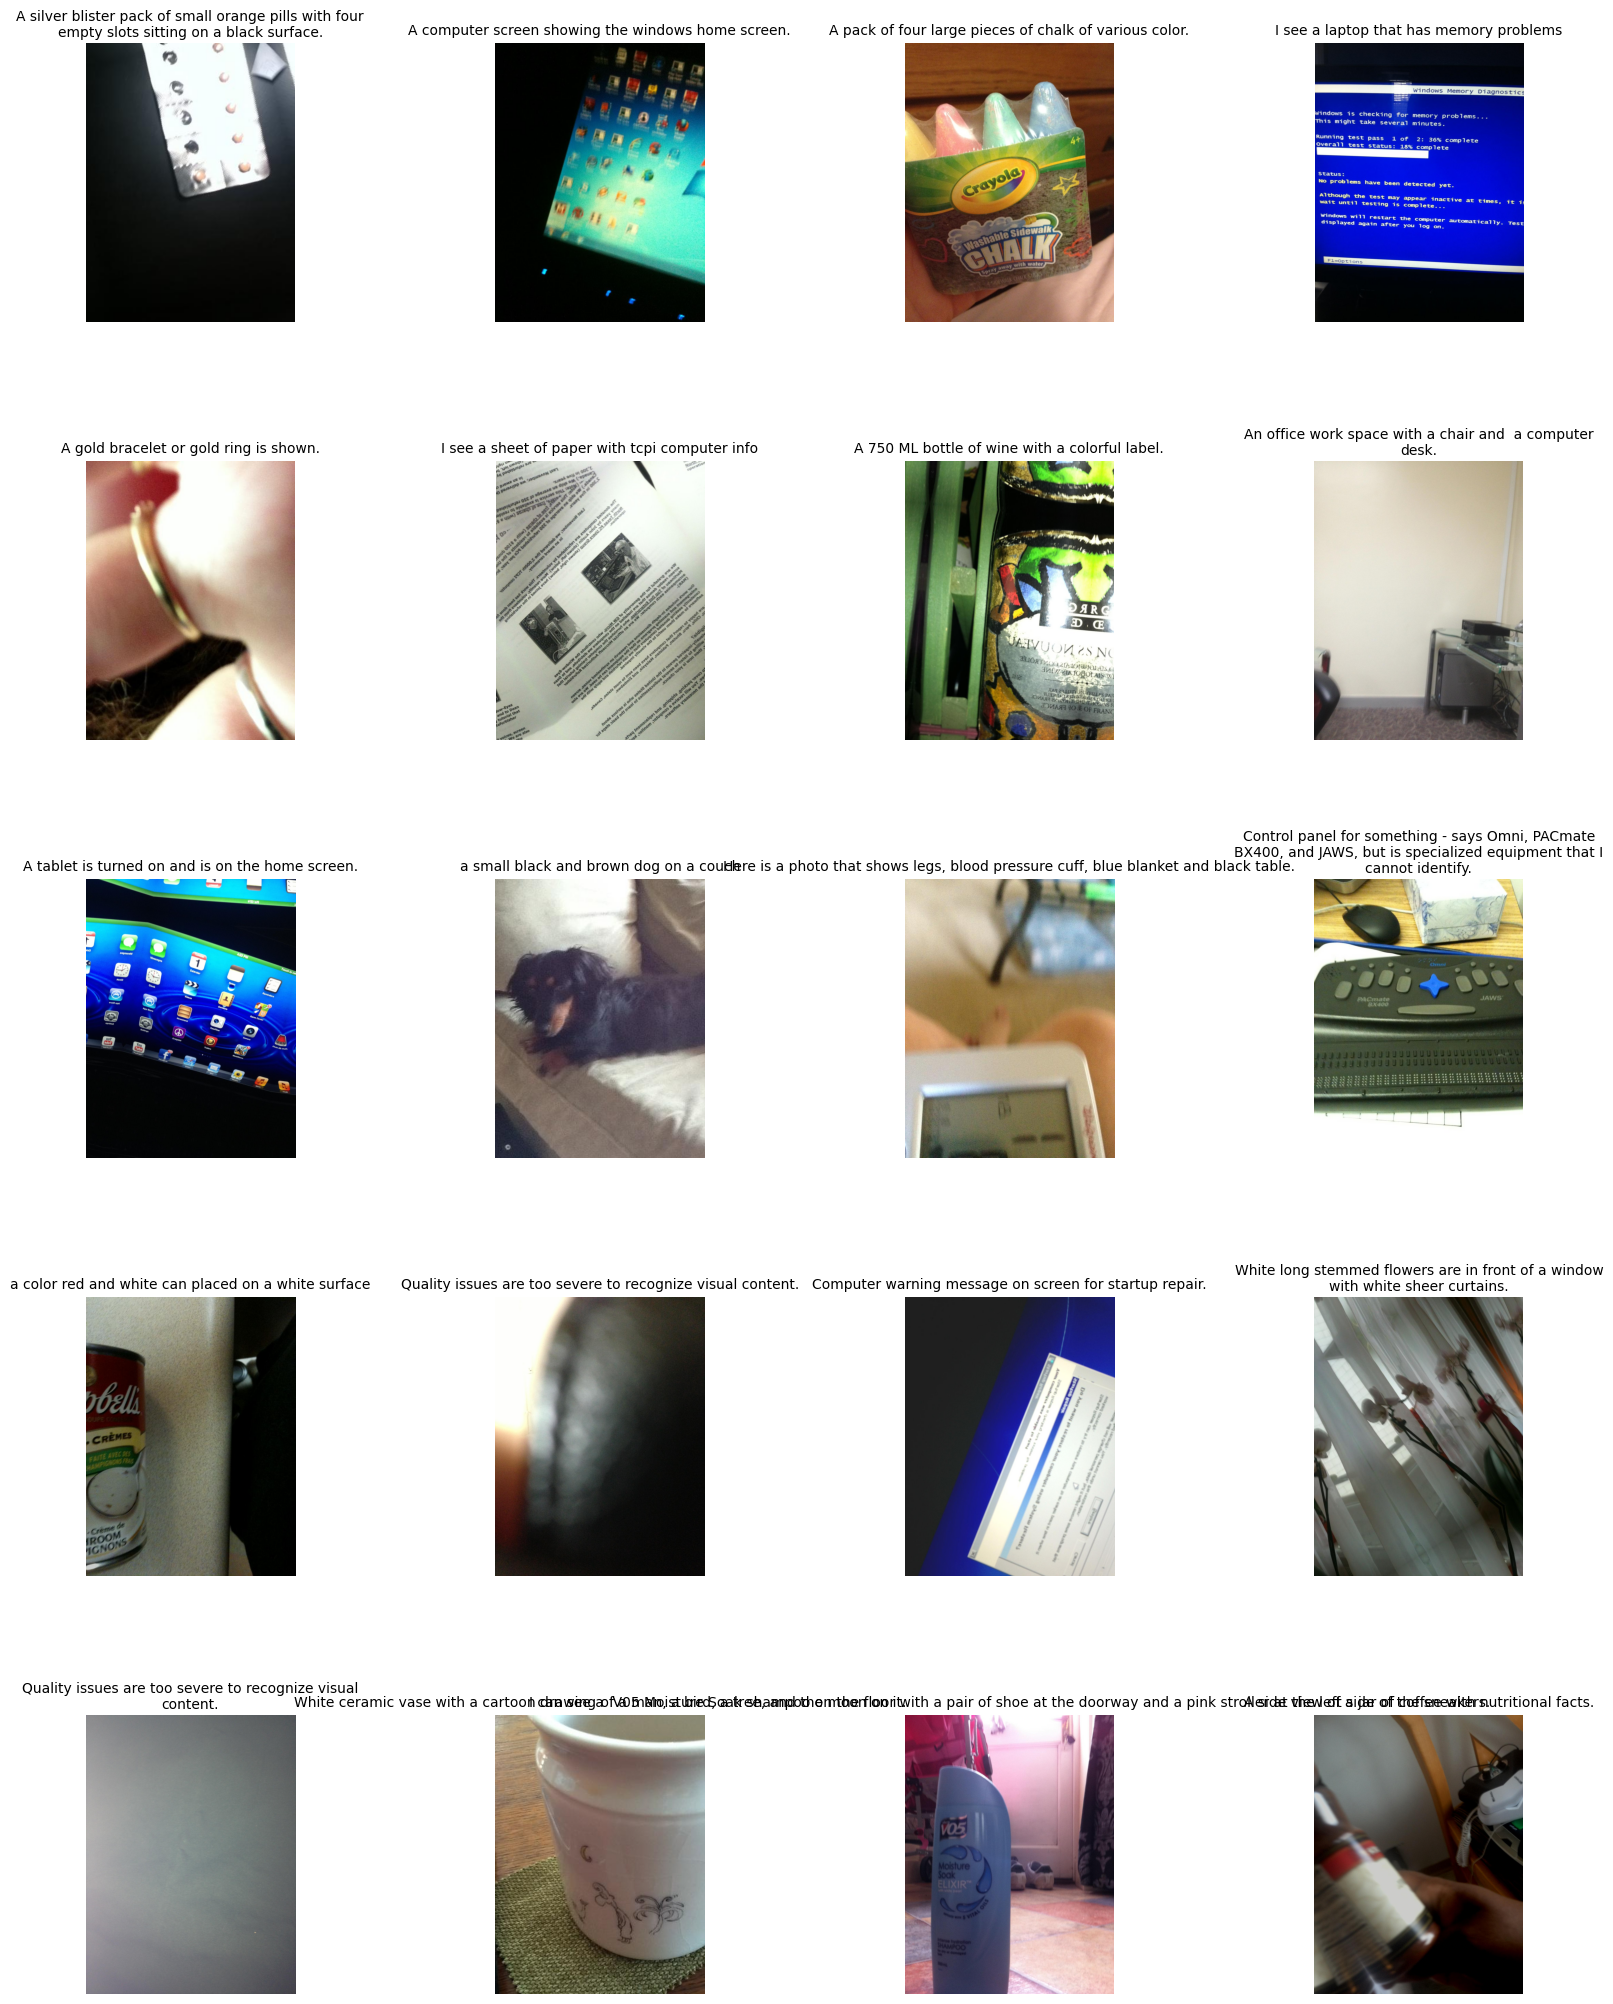

In [29]:
# Sample 20 images from the training dataset
sampled_df = train_data.sample(n=20).reset_index(drop=True)

# Function to load and display image
def show_image(row, ax):
    with Image.open('/kaggle/working/saved_data/train/' + row['filename']) as img:
        ax.imshow(img)
        ax.set_title(row['caption'], fontsize=10, wrap=True)
        ax.axis('off')

# Create subplots for displaying images and captions
fig, axs = plt.subplots(5, 4, figsize=(16, 20))

# Iterate over sampled data and plot images with captions
for i, row in sampled_df.iterrows():
    ax = axs[i // 4, i % 4]
    show_image(row, ax)

# Adjust layout and display plot
plt.tight_layout()
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

Loading Dataset

In [30]:
train_ds = Dataset(train_data,valid_tfms,'train')
val_ds = Dataset(val_data,valid_tfms,'val')

The collate_fn function is used in PyTorch DataLoader to collate (combine) a list of samples into a batch. Here's a short summary of what it does:

Input:
batch: A list of samples, where each sample is a tuple containing image tensors, input token ids, and label token ids.
Processing:
It unpacks the batch into three separate lists: images, input_ids, and labels.
Converts the list of image tensors into a single tensor by stacking them along a new dimension (dim=0).
Utilizes the tokenizer to pad the input token ids and label token ids to the longest sequence length in the batch.
Masks the padding tokens in the labels by setting them to -100 where the input token ids are padded.
Output:
Returns a tuple containing the batched image tensor, padded input token ids tensor, and padded label token ids tensor.
In summary, this function preprocesses a batch of samples for training or evaluation in a sequence-to-sequence task, ensuring that inputs and labels are properly padded and aligned for model processing.

In [31]:
def collate_fn(batch):
    images, input_ids, labels = zip(*batch)
    
    image = torch.stack(images,dim=0)
    
    encoding = tokenizer.pad(
        {'input_ids':input_ids},
        padding='longest',
        return_attention_mask=False,
        return_tensors='pt'
    )
    input_ids = encoding['input_ids']
    
    encoding = tokenizer.pad(
        {'input_ids':labels},
        padding='longest',
        return_attention_mask=False,
        return_tensors='pt'
    )
    labels = encoding['input_ids']
    
    mask = (input_ids!=tokenizer.pad_token_id).long()
    labels[mask==0]=-100
    
    return image, input_ids, labels

# **Transformer**

**Self Attention Block**

This GPT2Attention class implements the attention mechanism used in the GPT-2 model. Here's a short summary of its functionality:

Initialization:

It takes a config object containing parameters such as embedding dimension, number of heads, sequence length, and dropout probabilities.
Initializes linear layers for computing query, key, and value vectors, and linear projection layer for output.
Registers a buffer for the triangular mask used to mask out future tokens in the self-attention mechanism.
Defines dropout layers for attention and residual connections.
Forward Method:

Computes query, key, and value vectors using linear transformations of the input tensor x.
Reshapes and permutes these vectors to prepare for multi-head attention computation.
Computes scaled dot-product attention scores, applies the triangular mask to mask out future tokens, and applies softmax to obtain attention weights.
Applies dropout to the attention weights and computes the weighted sum of values.
Projects the weighted sum back to the original embedding dimension using linear transformation and applies residual dropout.
Returns the output tensor.
In summary, the GPT2Attention class encapsulates the multi-head self-attention mechanism used in the GPT-2 model, allowing for efficient computation of attention-based transformations on input sequences.

In [32]:
class GPT2Attention(nn.Module):
    def __init__(self, config):
        super().__init__()
        # Extracting configuration parameters
        self.embed_dim = config.embed_dim
        self.n_heads = config.num_heads
        assert self.embed_dim % self.n_heads == 0, 'embedding dimension must be divisible by number of heads'
        self.head_size = self.embed_dim // self.n_heads
        self.seq_len = config.seq_len
        
        # Linear layers for query, key, value computation
        self.c_attn = nn.Linear(self.embed_dim, self.head_size * self.n_heads * 3, bias=True)
        # Scaling factor for attention scores
        self.scale = self.head_size ** -0.5
        
        # Mask for preventing attention to future tokens
        self.register_buffer('mask', torch.tril(torch.ones(1, 1, self.seq_len, self.seq_len)))
        
        # Linear layer for post-attention processing
        self.c_proj = nn.Linear(self.embed_dim, self.embed_dim, bias=True)
        
        # Dropout layers
        self.attn_dropout = nn.Dropout(config.attention_dropout)
        self.resid_dropout = nn.Dropout(config.residual_dropout)
        
        
    def forward(self, x):
        # Extracting dimensions of input tensor
        b, t, c = x.shape
        
        # Compute queries, keys, and values
        q, k, v = self.c_attn(x).chunk(3, dim=-1)
        # Reshape and permute for multi-head attention
        q = q.view(b, t, self.n_heads, self.head_size).permute(0, 2, 1, 3)
        k = k.view(b, t, self.n_heads, self.head_size).permute(0, 2, 1, 3)
        v = v.view(b, t, self.n_heads, self.head_size).permute(0, 2, 1, 3)
        
        # Compute scaled dot-product attention
        qk_t = (q @ k.transpose(-2, -1)) * self.scale
        # Apply mask to prevent attention to future tokens
        qk_t = qk_t.masked_fill(self.mask[:, :, :t, :t] == 0, float('-inf'))
        # Apply softmax and dropout
        qk_t = F.softmax(qk_t, dim=-1)
        weights = self.attn_dropout(qk_t)
        
        # Compute weighted sum of values
        attention = weights @ v
        attention = attention.permute(0, 2, 1, 3).contiguous().view(b, t, c)
        
        # Post-attention processing and residual connection
        out = self.c_proj(attention)
        out = self.resid_dropout(out)
        
        return out


**Cross Attention Block**

The GPT2CrossAttention class implements cross-attention mechanism used in the GPT-2 model. Here's a concise summary of its functionalities:

Initialization:

It takes a config object containing parameters such as embedding dimension, number of heads, and dropout probabilities.
Initializes linear layers for computing query, key, and value vectors, and linear projection layer for output.
Applies weight initialization to linear layers.
Forward Method:

Computes query, key, and value vectors using linear transformations of input tensors q, k, and v.
Reshapes and permutes these vectors to prepare for multi-head attention computation.
Computes scaled dot-product attention scores, applies softmax to obtain attention weights, and applies dropout.
Computes the weighted sum of values using attention weights and projects it back to the original embedding dimension.
Applies residual dropout and returns the output tensor.
In essence, the GPT2CrossAttention class encapsulates the cross-attention mechanism used in the GPT-2 model, enabling efficient computation of attention-based transformations between different sequences.

In [33]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class GPT2CrossAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        # Extracting configuration parameters
        self.embed_dim = config.embed_dim
        self.n_heads = config.num_heads
        assert self.embed_dim % self.n_heads == 0, 'embedding dimension must be divisible by number of heads'
        self.head_size = self.embed_dim // self.n_heads
        self.seq_len = config.seq_len
        
        # Linear layers for queries, keys, and values
        self.q = nn.Linear(self.embed_dim, self.embed_dim)
        self.k = nn.Linear(self.embed_dim, self.embed_dim)
        self.v = nn.Linear(self.embed_dim, self.embed_dim)
        # Scaling factor for attention scores
        self.scale = self.head_size ** -0.5
        
        # Linear layer for post-attention processing
        self.c_proj = nn.Linear(self.embed_dim, self.embed_dim, bias=True)
        
        # Dropout layers
        self.attn_dropout = nn.Dropout(config.attention_dropout)
        self.resid_dropout = nn.Dropout(config.residual_dropout)
        
        # Weight initialization
        self.apply(self._init_weights)
        
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        
    def forward(self, q, k, v):
        # Extracting dimensions of input tensors
        b, t, c = q.shape
        
        # Linear transformations for queries, keys, and values
        q = self.q(q)
        k = self.k(k)
        v = self.v(v)
        
        # Reshape and permute for multi-head attention
        q = q.view(b, q.size(1), self.n_heads, self.head_size).permute(0, 2, 1, 3)
        k = k.view(b, k.size(1), self.n_heads, self.head_size).permute(0, 2, 1, 3)
        v = v.view(b, v.size(1), self.n_heads, self.head_size).permute(0, 2, 1, 3)
        
        # Compute scaled dot-product attention
        qk_t = (q @ k.transpose(-2, -1)) * self.scale
        qk_t = F.softmax(qk_t, dim=-1)
        weights = self.attn_dropout(qk_t)
        
        # Compute weighted sum of values
        attention = weights @ v
        attention = attention.permute(0, 2, 1, 3).contiguous().view(b, t, c)
        
        # Post-attention processing and residual connection
        out = self.c_proj(attention)
        out = self.resid_dropout(out)
        
        return out


**Feed Forward layer**

The GPT2MLP class defines the multi-layer perceptron (MLP) component used in the GPT-2 model. Here's a concise summary of its functionality:

Initialization:

It takes a config object containing parameters such as embedding dimension, MLP ratio, and dropout probability.
Initializes linear layers for the fully connected (c_fc) and projection (c_proj) stages of the MLP.
Utilizes the GELU activation function and dropout layer.
Forward Method:

Accepts an input tensor x.
Applies the fully connected layer (c_fc) followed by the GELU activation function.
Passes the result through the projection layer (c_proj).
Applies dropout to the output tensor.
Returns the processed tensor.
In summary, the GPT2MLP class implements the MLP component of the GPT-2 model, responsible for applying non-linear transformations to intermediate representations.

In [34]:
class GPT2MLP(nn.Module):
    def __init__(self, config):
        super(GPT2MLP, self).__init__()
        self.embed_dim = config.embed_dim
        self.mlp_ratio = config.mlp_ratio
        self.mlp_dropout = config.mlp_dropout
        
        self.fc1 = nn.Linear(self.embed_dim, self.embed_dim * self.mlp_ratio)
        self.fc2 = nn.Linear(self.embed_dim * self.mlp_ratio, self.embed_dim)
        self.activation = nn.GELU()
        self.dropout = nn.Dropout(self.mlp_dropout)
        
    def forward(self, x):
        # Apply the first fully connected layer and activation function
        x = self.fc1(x)
        x = self.activation(x)
        
        # Apply the second fully connected layer and dropout
        x = self.fc2(x)
        x = self.dropout(x)
        
        return x


**Decoder Block**

In [35]:
class GPT2Block(nn.Module):
    def __init__(self,config):
        super().__init__()
        self.embed_dim = config.embed_dim
        self.ln_1 = nn.LayerNorm(self.embed_dim)
        self.attn = GPT2Attention(config)
        self.ln_2 = nn.LayerNorm(self.embed_dim)
        self.mlp = GPT2MLP(config)
        self.ln_3 = nn.LayerNorm(self.embed_dim)
        self.cross_attn = GPT2CrossAttention(config)
        
    def forward(self,x,enc_out):
        x = x+self.attn(self.ln_1(x))
        x = x+self.cross_attn(self.ln_2(x),enc_out,enc_out)
        x = x+self.mlp(self.ln_3(x))
        return x

# **VIT Model**


The VisionGPT2Model class is a custom model that combines a Vision Transformer (ViT) with a GPT-2 language model. Here's a brief summary of its functionality:

Initialization:

The constructor initializes the model with a configuration object.
It loads a pre-trained Vision Transformer (vit_base_patch16_224) and extracts its components such as patch embedder, position embeddings, and transformer blocks.
Initializes the language model components including token embeddings, position embeddings, dropout layers, and a linear layer for the language modeling head.
Fine-tuning and Unfreezing:

Methods pretrained_layers_trainable and unfreeze_gpt_layers enable fine-tuning and unfreezing of specific layers for transfer learning.
Loading Pre-trained Weights:

The from_pretrained class method loads pre-trained weights from a GPT-2 model (gpt2) and initializes the model's parameters accordingly.
Forward Pass:

The forward method accepts image tensors and token sequences as input.
It processes the image through the Vision Transformer and the token sequences through the GPT-2 language model.
During training, it calculates the language modeling loss using cross-entropy.
During generation, it predicts subsequent tokens based on the input sequence and image.
Sequence Generation:

The generate method generates a sequence of tokens conditioned on the input image and initial token sequence.
It iteratively predicts tokens and appends them to the sequence until a maximum length or end-of-sequence token is reached.
Overall, the VisionGPT2Model class integrates vision and language processing capabilities, enabling tasks such as image captioning and multimodal sequence generation.







In [36]:
class VisionGPT2Model(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        # Initialize Vision Transformer
        self.vit = create_model('vit_base_patch16_224', pretrained=True, num_classes=0)
        self.patch_embed = self.vit.patch_embed
        self.num_patches = self.patch_embed.num_patches
        self.cls_token = self.vit.cls_token
        self.embed_len = self.num_patches + self.vit.num_prefix_tokens
        self.pos_embed = self.vit.pos_embed
        self.pos_drop = nn.Dropout(p=0.)
        self.blocks = nn.ModuleList([self.vit.blocks[i] for i in range(config.depth)])

        # Initialize GPT-2 Transformer
        self.transformer = nn.ModuleDict({
            'wte': nn.Embedding(config.vocab_size, config.embed_dim),
            'wpe': nn.Embedding(config.seq_len, config.embed_dim),
            'drop': nn.Dropout(config.emb_dropout),
            'blocks': nn.ModuleList([GPT2Block(config) for _ in range(config.depth)]),
            'ln_f': nn.LayerNorm(config.embed_dim)
        })
        self.lm_head = nn.Linear(config.embed_dim, config.vocab_size, bias=False)
        self.transformer['wte'].weight = self.lm_head.weight

    def _pos_embed(self, x):
        x = torch.cat((self.cls_token.expand(x.shape[0], -1, -1), x), dim=1)
        x = x + self.pos_embed
        return self.pos_drop(x)

    def pretrained_layers_trainable(self, trainable=False):
        layers = [
            self.cls_token, self.patch_embed, self.pos_embed, self.blocks,
            self.transformer['wte'], self.transformer['wpe'],
            self.transformer['ln_f'], self.lm_head
        ]
        gpt_layers = [
            layer
            for gpt_block in self.transformer['blocks']
            for layer in (gpt_block.ln_1, gpt_block.ln_2, gpt_block.attn, gpt_block.mlp)
        ]
        layers.extend(gpt_layers)

        for layer in layers:
            if hasattr(layer, "parameters"):
                for param in layer.parameters():
                    param.requires_grad = trainable
            elif isinstance(layer, nn.Parameter):
                layer.requires_grad = trainable

        total_frozen_params = sum(p.numel() for p in self.parameters() if not p.requires_grad)
        print(f"{total_frozen_params=}")

    def unfreeze_gpt_layers(self):
        self.pretrained_layers_trainable(trainable=True)

    @classmethod
    def from_pretrained(cls, config):
        model = VisionGPT2Model(config)
        state_dict = model.state_dict()
        keys = state_dict.keys()
        ignore_matches = ['blocks.', 'cross_attn.', 'ln_3', 'cls_token', 'pos_embed', 'patch_embed.', '.attn.mask']
        vit_keys = [key for key in keys if any(match in key for match in ignore_matches)]
        gpt_keys = [key for key in keys if key not in vit_keys]

        gpt2_small = GPT2LMHeadModel.from_pretrained('gpt2')
        hf_state_dict = gpt2_small.state_dict()
        hf_keys = hf_state_dict.keys()
        hf_keys = [k for k in hf_keys if not k.endswith('.attn.masked_bias')]
        hf_keys = [k for k in hf_keys if not k.endswith('.attn.bias')]
        transposed = ['attn.c_attn.weight', 'attn.c_proj.weight', 'mlp.c_fc.weight', 'mlp.c_proj.weight']

        for k in hf_keys:
            if any(match in k for match in ignore_matches):
                continue
            if any(k.endswith(w) for w in transposed):
                assert hf_state_dict[k].shape[::-1] == state_dict[k].shape
                with torch.no_grad():
                    state_dict[k].copy_(hf_state_dict[k].t())
            else:
                assert hf_state_dict[k].shape == state_dict[k].shape
                with torch.no_grad():
                    state_dict[k].copy_(hf_state_dict[k])

        model.load_state_dict(state_dict)
        return model

    def forward(self, image, input_ids, labels=None):
        image = self.patch_embed(image)
        image = self._pos_embed(image)

        token_embeddings = self.transformer['wte'](input_ids)
        pos_embs = torch.arange(0, input_ids.size(1), device=input_ids.device)
        positional_embeddings = self.transformer['wpe'](pos_embs)
        input_ids = self.transformer['drop'](token_embeddings + positional_embeddings)

        for i, gpt_block in enumerate(self.transformer['blocks']):
            image = self.blocks[i](image)
            input_ids = gpt_block(input_ids, image)

        input_ids = self.transformer['ln_f'](input_ids)

        if labels is not None:
            lm_logits = self.lm_head(input_ids)
            loss = nn.functional.cross_entropy(lm_logits.view(-1, lm_logits.shape[-1]), labels.view(-1))
            return loss

        lm_logits = self.lm_head(input_ids[:, -1:, :])
        return lm_logits

    def generate(self, image, sequence, max_tokens=50, temperature=1.0, deterministic=False):
        for _ in range(max_tokens):
            out = self(image, sequence)
            out = out[:, -1, :] / temperature
            probs = nn.functional.softmax(out, dim=-1)
            if deterministic:
                next_token = torch.argmax(probs, dim=-1, keepdim=True)
            else:
                next_token = torch.multinomial(probs, num_samples=1)
            sequence = torch.cat([sequence, next_token], dim=1)
            if next_token.item() == GPT2TokenizerFast.from_pretrained('gpt2').eos_token_id:
                break

        return sequence.cpu().flatten()

# **Trainer**

This code implements training and evaluation pipelines for a Vision-GPT-2 model for image captioning. Here's a breakdown of what it does:

Model Configuration:

Defines configurations for the Vision-GPT-2 model, including vocabulary size, embedding dimensions, number of attention heads, sequence length, model depth, and various dropout probabilities.
Training Configuration:

Sets up training configurations such as the number of epochs, freeze epochs for GPT-2 layers, freeze epochs for all layers, learning rate, device (CPU or GPU), model saving path, and batch size.
Data Loading:

Creates data loaders for training and validation datasets, specifying batch sizes, shuffling, pinning memory, number of worker processes, and a collate function to process batches.
Model Initialization:

Initializes the Vision-GPT-2 model with the specified configurations and moves it to the specified device (CPU or GPU).
Freezes the pre-trained layers of the model to prevent weight updates during initial training.
Tokenizer Setup:

Loads the GPT-2 tokenizer and sets the padding token to the end-of-sequence token.
Scaler, Optimizer, and Scheduler Initialization:

Sets up a gradient scaler for mixed precision training.
Initializes the Adam optimizer with the specified learning rate.
Sets up a one-cycle learning rate scheduler.
Training Loop:

Implements functions for saving and loading the model, cleaning up memory, training one epoch, and validating one epoch.
Iterates over epochs, unfreezing GPT-2 layers and all layers at specified epochs, trains the model, evaluates it on the validation set, and saves the best-performing model based on validation perplexity.
Caption Generation:

Defines a function for generating captions from images using the trained model.
Opens an image, preprocesses it, generates a caption conditioned on a starting token, and decodes the generated token IDs into text.
Overall, this code orchestrates the training, evaluation, and caption generation processes for the Vision-GPT-2 model, enabling the model to learn to generate captions for images.

![](https://ankur3107.github.io/assets/images/vision-encoder-decoder.png)

In [37]:
model_config = SimpleNamespace(
    vocab_size = 50_257,
    embed_dim = 768,
    num_heads = 12,
    seq_len = 1024,
    depth = 12,
    attention_dropout = 0.2,
    residual_dropout = 0.2,
    mlp_ratio = 4,
    mlp_dropout = 0.2,
    emb_dropout = 0.2,
)

train_config = SimpleNamespace(
    epochs = 11,
    freeze_epochs_gpt = 1,
    freeze_epochs_all = 2,
    lr = 1e-4,
    device = 'cuda',
    model_path = Path('captioner'),
    batch_size = 16
)

train_dl = torch.utils.data.DataLoader(train_ds, batch_size=train_config.batch_size, shuffle=True, pin_memory=True, num_workers=2, persistent_workers=True, collate_fn=collate_fn)
val_dl = torch.utils.data.DataLoader(val_ds, batch_size=train_config.batch_size, shuffle=False, pin_memory=True, num_workers=2, persistent_workers=True, collate_fn=collate_fn)

model = VisionGPT2Model(model_config).to(train_config.device)
model.pretrained_layers_trainable(trainable=False)

print(f'trainable parameters: {sum([p.numel() for p in model.parameters() if p.requires_grad])}')

tokenizer = GPT2TokenizerFast.from_pretrained('gpt2')
tokenizer.pad_token = tokenizer.eos_token

scaler = GradScaler()
optim = torch.optim.Adam(model.parameters(), lr=train_config.lr / 25.)
sched = torch.optim.lr_scheduler.OneCycleLR(
    optim,
    max_lr=train_config.lr,
    epochs=train_config.epochs,
    steps_per_epoch=len(train_dl)
)

metrics = pd.DataFrame()
metrics[['train_loss', 'train_perplexity', 'val_loss', 'val_perplexity']] = None

gen_tfms = A.Compose([
    A.Resize(224, 224),
    A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5], always_apply=True),
    ToTensorV2()
])

def save_model():
    train_config.model_path.mkdir(exist_ok=True)
    torch.save(model.state_dict(), train_config.model_path / 'captioner.pt')

def load_best_model():
    sd = torch.load(train_config.model_path / 'captioner.pt')
    model.load_state_dict(sd)

def clean():
    gc.collect()
    torch.cuda.empty_cache()

def train_one_epoch(epoch):
    model.train()
    prog = tqdm(train_dl, total=len(train_dl))
    running_loss = 0.

    for image, input_ids, labels in prog:
        with autocast():
            image = image.to(train_config.device)
            input_ids = input_ids.to(train_config.device)
            labels = labels.to(train_config.device)

            loss = model(image, input_ids, labels)

            scaler.scale(loss).backward()
            scaler.step(optim)
            scaler.update()
            sched.step()
            optim.zero_grad(set_to_none=True)

            running_loss += loss.item()
            prog.set_description(f'train loss: {loss.item():.3f}')

        del image, input_ids, labels, loss

    train_loss = running_loss / len(train_dl)
    train_pxp = np.exp(train_loss)
    metrics.loc[epoch, ['train_loss', 'train_perplexity']] = (train_loss, train_pxp)

@torch.no_grad()
def valid_one_epoch(epoch):
    model.eval()
    prog = tqdm(val_dl, total=len(val_dl))
    running_loss = 0.

    for image, input_ids, labels in prog:
        with autocast():
            image = image.to(train_config.device)
            input_ids = input_ids.to(train_config.device)
            labels = labels.to(train_config.device)

            loss = model(image, input_ids, labels)
            running_loss += loss.item()
            prog.set_description(f'valid loss: {loss.item():.3f}')

        del image, input_ids, labels, loss

    val_loss = running_loss / len(val_dl)
    val_pxp = np.exp(val_loss)
    metrics.loc[epoch, ['val_loss', 'val_perplexity']] = (val_loss, val_pxp)
    return val_pxp

def fit():
    best_pxp = 1e9
    best_epoch = -1
    prog = tqdm(range(train_config.epochs))

    for epoch in prog:
        if epoch == train_config.freeze_epochs_gpt:
            model.unfreeze_gpt_layers()
            print('unfreezing GPT2 entirely...')

        if epoch == train_config.freeze_epochs_all:
            model.pretrained_layers_trainable(trainable=True)

        train_one_epoch(epoch)
        clean()
        val_pxp = valid_one_epoch(epoch)
        clean()
        print(metrics.tail(1))

        if val_pxp < best_pxp:
            best_pxp = val_pxp
            best_epoch = epoch
            print('saving best model...')
            save_model()

    return {
        'best_perplexity': best_pxp,
        'best_epoch': best_epoch
    }

@torch.no_grad()
def generate_caption(image, max_tokens=50, temperature=1.0, deterministic=False):
    model.eval()
    image = Image.open(image).convert('RGB')
    image = np.array(image)
    image = gen_tfms(image=image)['image']
    image = image.unsqueeze(0).to(train_config.device)
    sequence = torch.ones(1, 1).to(device=train_config.device).long() * tokenizer.bos_token_id
    caption = model.generate(image, sequence, max_tokens, temperature, deterministic)
    caption = tokenizer.decode(caption.numpy(), skip_special_tokens=True)
    return caption

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

total_frozen_params=210236928
trainable parameters: 28368384


In [38]:

fit()

  0%|          | 0/11 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  0%|          | 0/3100 [00:00<?, ?it/s]

You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before th

  0%|          | 0/775 [00:00<?, ?it/s]

You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


  train_loss train_perplexity  val_loss val_perplexity
0   8.402896       4459.96312  7.740912    2300.569236
saving best model...
total_frozen_params=0
unfreezing GPT2 entirely...


  0%|          | 0/3100 [00:00<?, ?it/s]

  0%|          | 0/775 [00:00<?, ?it/s]

  train_loss train_perplexity  val_loss val_perplexity
1   5.244092        189.44368  4.898063     134.029881
saving best model...
total_frozen_params=0


  0%|          | 0/3100 [00:00<?, ?it/s]

  0%|          | 0/775 [00:00<?, ?it/s]

  train_loss train_perplexity  val_loss val_perplexity
5   2.827733        16.907086  4.529482      92.710523


  0%|          | 0/3100 [00:00<?, ?it/s]

  0%|          | 0/775 [00:00<?, ?it/s]

  train_loss train_perplexity  val_loss val_perplexity
6   2.286183         9.837321  4.618229     101.314491


  0%|          | 0/3100 [00:00<?, ?it/s]

  0%|          | 0/775 [00:00<?, ?it/s]

  train_loss train_perplexity  val_loss val_perplexity
7   1.738543         5.689046  4.731733     113.492064


  0%|          | 0/3100 [00:00<?, ?it/s]

  0%|          | 0/775 [00:00<?, ?it/s]

  train_loss train_perplexity  val_loss val_perplexity
8   1.254154         3.504872  4.894759     133.587821


  0%|          | 0/3100 [00:00<?, ?it/s]

  0%|          | 0/775 [00:00<?, ?it/s]

  train_loss train_perplexity  val_loss val_perplexity
9   0.929655         2.533635  5.013155     150.378499


  0%|          | 0/3100 [00:00<?, ?it/s]

  0%|          | 0/775 [00:00<?, ?it/s]

   train_loss train_perplexity  val_loss val_perplexity
10   0.785757         2.194068  5.046169     155.425861


{'best_perplexity': 92.32416246137495, 'best_epoch': 4}

# Test Part

This function generates a caption for an image using the best-trained Vision-GPT-2 model, previously saved during training. It prepares the image, generates a caption sequence, and decodes it into a human-readable caption using the GPT-2 tokenizer. Finally, it returns the generated caption as a string.

In [41]:
def generate_caption_with_best_model(image, max_tokens=50, temperature=1.0, deterministic=False):
    load_best_model()

    model.eval()
    image = Image.open(image).convert('RGB')
    image = np.array(image)
    image = gen_tfms(image=image)['image']
    image = image.unsqueeze(0).to(train_config.device)
    sequence = torch.ones(1, 1).to(device=train_config.device).long() * tokenizer.bos_token_id
    caption = model.generate(image, sequence, max_tokens, temperature, deterministic)
    caption = tokenizer.decode(caption.numpy(), skip_special_tokens=True)
    return caption
print(generate_caption_with_best_model('/kaggle/input/val-dataset/val/VizWiz_val_00000000.jpg'))

levision screen on a computer monitor boxes......................... been about force/ check on seems to head the a computerboard is. screen screen time


In [48]:
import os
import pandas as pd

# Path to the directory containing the images
image_dir = "/kaggle/input/test-dataset/images"

# Get a list of image file names
image_files = sorted(os.listdir(image_dir))

# Initialize lists to store image file names and corresponding captions
image_names = []
captions = []

# Loop through each image file
for image_name in image_files:
    # Generate caption for the current image
    caption = generate_caption_with_best_model(os.path.join(image_dir, image_name))
    
    # Append image name and caption to the respective lists
    image_names.append(image_name)
    captions.append(f'{caption}')
    print(image_name)

# Create a DataFrame from the lists
data = {'image': image_names, 'caption': captions}
df = pd.DataFrame(data)

# Write the DataFrame to a CSV file
df.to_csv('image_captions.csv', index=False)

VizWiz_test_00007031.jpg
VizWiz_test_00007032.jpg
VizWiz_test_00007033.jpg
VizWiz_test_00007034.jpg
VizWiz_test_00007035.jpg
VizWiz_test_00007036.jpg
VizWiz_test_00007037.jpg
VizWiz_test_00007038.jpg
VizWiz_test_00007039.jpg
VizWiz_test_00007040.jpg
VizWiz_test_00007041.jpg
VizWiz_test_00007042.jpg
VizWiz_test_00007043.jpg
VizWiz_test_00007044.jpg
VizWiz_test_00007045.jpg
VizWiz_test_00007046.jpg
VizWiz_test_00007047.jpg
VizWiz_test_00007048.jpg
VizWiz_test_00007049.jpg
VizWiz_test_00007050.jpg
VizWiz_test_00007051.jpg
VizWiz_test_00007052.jpg
VizWiz_test_00007053.jpg
VizWiz_test_00007054.jpg
VizWiz_test_00007055.jpg
VizWiz_test_00007056.jpg
VizWiz_test_00007057.jpg
VizWiz_test_00007058.jpg
VizWiz_test_00007059.jpg
VizWiz_test_00007060.jpg
VizWiz_test_00007061.jpg
VizWiz_test_00007062.jpg
VizWiz_test_00007063.jpg
VizWiz_test_00007064.jpg
VizWiz_test_00007065.jpg
VizWiz_test_00007066.jpg
VizWiz_test_00007067.jpg
VizWiz_test_00007068.jpg
VizWiz_test_00007069.jpg
VizWiz_test_00007070.jpg


In [49]:
df

,image,caption
0,VizWiz_test_00007031.jpg,storage ent whatThese over showing organic th...
1,VizWiz_test_00007032.jpg,of meat panel is and a blue Meal for food tex...
2,VizWiz_test_00007033.jpg,ALL of a bottle orup for important looks in th...
3,VizWiz_test_00007034.jpg,of frozen for frozen rotated chicken and Bake...
4,VizWiz_test_00007035.jpg,for a post that based unit CD Tr and a singer...
...,...,...
640,VizWiz_test_00007995.jpg,a a laptop of a computer showing keyboard hol...
641,VizWiz_test_00007996.jpg,OF of a glass is that containerpad is to its....
642,VizWiz_test_00007997.jpg,s image a window programs for a laptop for a g...
643,VizWiz_test_00007998.jpg,AP displayed holding card card A from thumbED...
